In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
def load_dataset(shuffle=True): 
    def irisnames_to_index(iris_name):
        if iris_name == b'Iris-setosa': # the b is to indicate that it's a string or something
            return 0
        elif iris_name == b'Iris-versicolor':
            return 1
        elif iris_name == b'Iris-virginica':
            return 2
        else:
            print('uh oh.')

    def unison_shuffle_data(a,b): # shuffles two 2D arrays, a and b, in unison
        assert np.shape(a)[1] == np.shape(b)[1] # since in partice, a and b are X and Y, of shapes (n_x,m) and (n_y,m), we make sure we're looking at the same number of examples
        p = np.random.permutation(np.shape(a)[1]) # returns a randomly ordered array of integers leading up to len(a)
        return a[:,p],b[:,p] # return two arrays, shuffled based on the order of the randomly permuted integers of p
            
    with open('iris.data','r') as f:
        XY = np.loadtxt(f,delimiter=',',converters={-1:irisnames_to_index}) # the converters dictionary converts entries in the last column by calling irisnames_to_index !
        X_tot = XY[:,: 4].T  # X is a matrix of shape (n_x,m)
        Ytemp = XY[:,4 :].T  # Ytemp is a matrix of shape (1,m). dim0 is a number (0, 1, or 2). Let's convert that to a one-hot vector
        m_tot = np.shape(Ytemp)[1]
        Y_tot = np.eye(3)[Ytemp[0].astype(int)].T # now we have Y, a matrix of shape (n_y,m)! dim0 is a one-hot array, indicating the plant type!
        if shuffle:
            X_tot,Y_tot = unison_shuffle_data(X_tot,Y_tot)
        return X_tot,Y_tot

In [3]:
X_tot,Y_tot = load_dataset() # we pull up all the X and Y data we have. Note that is is unshuffled.
m_tot = np.shape(X_tot)[1]
X_train = X_tot[:, : 100] # we take the first 100 examples of X_tot as training data
X_test = X_tot[:,100 :] # we take the last 50 examples of X_tot as test data
Y_train = Y_tot[:,: 100] # same idea with Y labels
Y_test = Y_tot[:,100 :]
assert np.shape(X_train)[1] == np.shape(Y_train)[1]
m_train = np.shape(X_train)[1]
m_test = np.shape(Y_train)[1]

# Now, we have 100 examples of training data (X_train,Y_train) and 50 examples of test data (X_test,Y_test)! 

In [4]:
def initialize_parameters(n_x,n_y): # this is where we decide the NN architecture. Let's take n_x as an argument, since our first layer weights need to deal with that. Same idea with n_y
    parameters = {'W1':None,'b1':None,'W2':None,'b2':None,'W3':None,'b3':None}
    # randomly initializing parameters to be in Gaussian distribution, with mean 0 and variance 1
    parameters['W1'] = np.random.randn(5,n_x)*np.sqrt(2/(n_x)) # actually initializing w He initialization
    parameters['b1'] = np.random.randn(5,1)*np.sqrt(2/(n_x))
    parameters['W2'] = np.random.randn(6,5)*np.sqrt(2/(5))
    parameters['b2'] = np.random.randn(6,1)*np.sqrt(2/(5))
    parameters['W3'] = np.random.randn(n_y,6)*np.sqrt(2/(6))
    parameters['b3'] = np.random.randn(n_y,1)*np.sqrt(2/(6))
    return parameters

def initialize_gradients(parameters):
    gradients={
        'dW1':None,
        'db1':None,
        'dW2':None,
        'db2':None,
        'dW3':None,
        'db3':None
    }
    gradients['dW1'] = np.zeros(np.shape(parameters['W1']))
    gradients['db1'] = np.zeros(np.shape(parameters['b1']))
    gradients['dW2'] = np.zeros(np.shape(parameters['W2']))
    gradients['db2'] = np.zeros(np.shape(parameters['b2']))
    gradients['dW3'] = np.zeros(np.shape(parameters['W3']))
    gradients['db3'] = np.zeros(np.shape(parameters['b3']))
    return gradients
    

In [5]:
def softmax(ZL): # inputs the vector Z of the final layer
    denom = np.sum((np.exp(ZL-np.max(ZL))),axis=0) # subtract max(x) to shrink values & avoid exploding gradient
    return np.divide((np.exp(ZL-np.max(ZL))),denom)
def sigmoid(ZL): # NOTE: decided to go w relu on all just bc it's easier to do derivatives
    return 1/(1+np.exp(-ZL))
def relu(ZL):
    return ZL.clip(min=0) # clips all negative elements of ZL, setting them to 0
def relu_back(AL): # computes derivative of relu fn, given the layer's activation
    mask = np.zeros(np.shape(AL))
    mask[AL>0]=1 # NOTE: technically, should be 1 or 0 based on ZL, not AL. But since AL = 0 iff ZL <= 0, this still works as shorthand
    mask[AL<=0]=0
#     print('AL is: ' +str(AL))
#     print('mask is: '+str(mask))
    return mask # return original value of AL if entry was nonnegative; 0 if negative

In [6]:
def forward_prop(X,Y,parameters,lambd=0): # given a set of parameters and our data, let's pass it forward and see what our guesses are.
    m = np.shape(X)[1]
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    Z1 = np.dot(W1,X)+b1
    A1 = relu(Z1)
    
    Z2 = np.dot(W2,A1)+b2
    A2 = relu(Z2)

    Z3 = np.dot(W3,A2)+b3
    A3 = softmax(Z3)

    assert np.shape(A3) == np.shape(Y)

    cost = 1/m*(np.sum(np.multiply(Y,-np.log(A3))) + 0.5*lambd*(np.sum(W3**2)+np.sum(W2**2)+np.sum(W1**2)))# let's do the cross entropy loss

    cache = (Z1,Z2,Z3,X,A1,A2,lambd) # saving these babies for later
    
    return A3,cache,cost

In [7]:
def back_prop(A3,Y,cache, parameters,gradients,debug=False):    # Note: A3, Y, and cache can be of however many examples we happen to want to input at once
    (Z1,Z2,Z3,X,A1,A2,lambd) = cache
    m = np.shape(X)[1]
    
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    

    dZ3 = A3-Y # someone calculated this here: https://deepnotes.io/softmax-crossentropy
    dW3 = 1/m*(np.dot(dZ3,A2.T) + lambd*np.sum(abs(W3)))
    db3 = 1/m*np.sum(dZ3,axis=1,keepdims=True) # so we don't get any rank 1 arrays

    if debug:
        print('Layer 3 Backprop:')
#         print('dA3 = '+str(np.average(dA3)))
        print('dZ3 = '+str(np.average(dZ3)))
        print('dW3 = '+str(np.average(dW3)))
        print('db3 = '+str(np.average(db3)))
        print('~'*30)
    
    dA2 = np.dot(W3.T,dZ3) # basically running fwd prop but in reverse! using W3.T to get from dZ3 to A2, instead of the other way around! :D
    dZ2 = np.multiply(dA2,relu_back(A2)) # derivative of the relu fn
    dW2 = 1/m*(np.dot(dZ2,A1.T) + lambd*np.sum(abs(W2)))# include regulaization term
    db2 = 1/m*np.sum(dZ2,axis=1,keepdims=True)
    
    if debug:
        print('Layer 2 Backprop:')
#         print('dA2 = '+str(np.average(dA2)))
        print('dZ2 = '+str(np.average(dZ2)))
        print('dW2 = '+str(np.average(dW2)))
        print('db2 = '+str(np.average(db2)))
        print('~'*30)
    
    dA1 = np.dot(W2.T,dZ2)
    dZ1 = np.multiply(dA1,relu_back(A1))
    dW1 = 1/m*(np.dot(dZ1,X.T) + lambd*np.sum(abs(W1)))
    db1 = 1/m*np.sum(dZ1,axis=1,keepdims=True)
    
    if debug:
        print('Layer 1 Backprop:')
#         print('dA1 = '+str(np.average(dA1)))
        print('dZ1 = '+str(np.average(dZ1)))
        print('dW1 = '+str(np.average(dW1)))
        print('db1 = '+str(np.average(db1)))
        print('~'*30)
    
    assert (np.shape(W1)==np.shape(dW1))
    assert (np.shape(b1)==np.shape(db1))
    assert (np.shape(W2)==np.shape(dW2))
    assert (np.shape(b2)==np.shape(db2))
    assert (np.shape(W3)==np.shape(dW3))
    assert (np.shape(b3)==np.shape(db3))
    
    
    gradients['dW1'] = dW1
    gradients['db1'] = db1
    gradients['dW2'] = dW2
    gradients['db2'] = db2
    gradients['dW3'] = dW3
    gradients['db3'] = db3
    
    
    return gradients
    

In [8]:
def update_parameters(parameters,gradients,learning_rate=0.005,clip=False):
    if clip:
        parameters['W1'] = parameters['W1'] - learning_rate*np.clip(gradients['dW1'],-5,5)
        parameters['b1'] = parameters['b1'] - learning_rate*np.clip(gradients['db1'],-5,5)
        parameters['W2'] = parameters['W2'] - learning_rate*np.clip(gradients['dW2'],-5,5)
        parameters['b2'] = parameters['b2'] - learning_rate*np.clip(gradients['db2'],-5,5)
        parameters['W3'] = parameters['W3'] - learning_rate*np.clip(gradients['dW3'],-5,5)
        parameters['b3'] = parameters['b3'] - learning_rate*np.clip(gradients['db3'],-5,5)  
    else:
        parameters['W1'] = parameters['W1'] - learning_rate*gradients['dW1']
        parameters['b1'] = parameters['b1'] - learning_rate*gradients['db1']
        parameters['W2'] = parameters['W2'] - learning_rate*gradients['dW2']
        parameters['b2'] = parameters['b2'] - learning_rate*gradients['db2']
        parameters['W3'] = parameters['W3'] - learning_rate*gradients['dW3']
        parameters['b3'] = parameters['b3'] - learning_rate*gradients['db3']
    return parameters

In [9]:
def plot_cost(costs,validation_costs=None):
    plt.plot(costs)
    plt.ylabel('Cost')
    plt.xlabel('Iterations')
    if validation_costs!=None:
        plt.plot(validation_costs)
        plt.legend(('Training Error','Validation Error'))
    else:
        plt.legend(('Training Error'))
    plt.show()

In [10]:
def train_model(X,Y,
                X_test=None,
                Y_test=None,
                epochs=10,
          show_epochs=True,
          lambd=0.5,
          starting_parameters=None,
          clip_grads=False,
          debug_backprop=False,
          plot_costs=True,
          learning_rate=0.005
         ):
    
    n_x = np.shape(X)[0]
    n_y = np.shape(Y)[0]
    
    if starting_parameters == None:
        parameters = initialize_parameters(n_x,n_y)
    else:
        parameters = starting_parameters
#     print('initial param = '+str(parameters['W3'][1,1]))
    gradients = initialize_gradients(parameters)
    
    costs=[]
    
    validation_costs=[]
    
    for ep in range(epochs):
        A3,cache,cost = forward_prop(X,Y,parameters,lambd=lambd)
        if X_test.all()!=None and Y_test.all()!=None:
            _,_,val_cost = forward_prop(X_test,Y_test,parameters,lambd=lambd)
            validation_costs.append(val_cost)
        gradients = back_prop(A3,Y,cache,parameters,gradients,debug=debug_backprop)
        parameters = update_parameters(parameters,gradients,clip=clip_grads,learning_rate=learning_rate)
        costs.append(cost)
        
        if show_epochs:
            print('Epoch '+str(ep) +':')
            print('cost = '+str(cost))
#             if clip_grads:
#                 print('grad = ' +str(np.clip(np.average(gradients['dW3']),-5,5)))
#             else:
#                 print('grad = ' +str(np.average(gradients['dW3'])))
#             print('param = '+str(np.average(parameters['W3'])))
            print('>'*50)

    if plot_costs:
        if X_test.all()!=None and Y_test.all()!=None:
            plot_cost(costs,validation_costs=validation_costs)
        else:
            plot_cost(costs)
            
    return parameters

In [11]:
def predict(X,Y,parameters):
#     print(np.shape(X))
    A3,_,cost = forward_prop(X,Y,parameters,lambd=0) # we only care about our predictions, A3!
    indices = np.argmax(A3,axis=0) # returns index of greatest value in a particular prediction (column) of A3
    pred = np.eye(3)[indices].T # converts indices to a one-hot vector! amazing!
    
    total_guesses = np.shape(X)[1]
    correct_guesses = np.sum(np.multiply(Y,pred)) # since Y and pred are both one-hot vectors, we can do elementwise multiplication. This will return 1 for matching columns, and 0 for non-matching ones. Summing these up will yield the number of correct guesses.
    
    accuracy = correct_guesses/total_guesses
    
    return accuracy

def single_predict(X,parameters,Y=np.zeros((3,1)),answer=None):
    X = np.asarray(X)
    Y = np.asarray(Y)
    X = X.reshape(-1,1) # makes X and Y into column vectors
    Y = Y.reshape(-1,1)
    A3,_,cost = forward_prop(X,Y,parameters,lambd=0)
    index = np.argmax(A3,axis=0) # returns index of greatest value in a particular prediction (column) of A3
    print('The Neural Network says: ')
    if index==0:
        print('Hmmm... I think this is an Iris-setosa.')
    elif index==1:
        print('Why of course! This must be an Iris-versicolor!')
    elif index==2:
        print('This is none other than an Iris-virginica.')
    else:
        print('Something went wrong...')
    print("* "*10)
    if Y.all()!=None and answer==None:
        if np.sum(Y*np.eye(3)[0].reshape(-1,1))==1:
            print('The correct answer is Iris-setosa.')
        elif np.sum(Y*np.eye(3)[1].reshape(-1,1))==1:
            print('The correct answer is Iris-versicolor.')
        elif np.sum(Y*np.eye(3)[2].reshape(-1,1))==1:
            print('The correct answer is Iris-virginica.')
    elif Y.all()==None and answer!=None:
        print('The correct answer is '+str(answer))
    
    

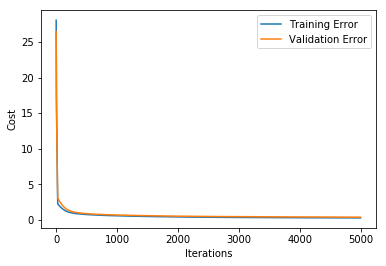

Accuracy on training data: 0.98
Accuracy on test data: 0.96
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
The Neural Network says: 
Why of course! This must be an Iris-versicolor!
* * * * * * * * * * 
The correct answer is Iris-versicolor.


In [24]:
# Now, let's put it all together!

parameters = train_model(
                    X_train[:,:],
                    Y_train[:,:],
                    X_test,
                    Y_test,
                    epochs=5000,
                    show_epochs=False,
                    clip_grads=False,
                    debug_backprop=False,
                    learning_rate = 0.001,
                  )
print("Accuracy on training data: " + str(predict(X_test[:,:],Y_test[:,:],parameters)))
print("Accuracy on test data: " + str(predict(X_train[:,:],Y_train[:,:],parameters)))

print('~'*50)

# single_predict(
#     [7.7,3.0,6.1,2.3],
#     parameters,
#     Y=[0,0,1]
# )
single_predict(
    X_test[:,5],
    parameters,
    Y=Y_test[:,5]
)

In [ ]:
# single_predict(
#     X_test[:,2],
#     parameters,
#     Y=Y_test[:,2]
# )

def guess(example_num):
    single_predict(X_test[:,example_num],parameters,Y=Y_test[:,example_num])
    
    
for i in range(10):
    guess(i)

In [13]:
# single_predict(
#     X_test[:,9],
#     parameters,
#     Y=Y_test[:,9]
# )

def interactive_guess(parameters):
    X = np.zeros((4,1))
    sepal_length = input('Sepal length (cm): ')
    try:
        sepal_length = float(sepal_length)
    except:
        print('Please enter a number!')
        return
    sepal_width = input('Sepal width (cm): ')
    try:
        sepal_width = float(sepal_width)
    except:
        print('Please enter a number!')
        return
    petal_length = input('Petal length (cm): ')
    try:
        petal_length = float(petal_length)
    except:
        print('Please enter a number!')
        return
    petal_width = input('Petal width (cm): ')
    try:
        petal_width = float(petal_width)
    except:
        print('Please enter a number!')
        return
    
    X[0][0]=sepal_length
    X[1][0]=sepal_width
    X[2][0]=petal_length
    X[3][0]=petal_width
    
    print(X)
    
    single_predict(X,parameters)


In [14]:
interactive_guess(parameters)

KeyboardInterrupt: 